# $R_0$ Analysis

One of the key quantities of interest for any infectious pathogen is the _reproductive number_, denoted $R_0$. 

This is the expected number of new cases caused by each case. 

Most estimates place this number for the 2019-nCov (novel coronavirus) as between 2 and 3. For example, Zhang et al ([link](https://www.ncbi.nlm.nih.gov/pubmed/32097725)), who analyzed the outbreak on the Diamond Princess cruise ship, say: 

> The Maximum-Likelihood (ML) value of R0 was 2.28 for COVID-19 outbreak at the early stage on the ship. The median with 95% confidence interval (CI) of R0 values was 2.28 (2.06-2.52).

In this notebook, we try to reproduce these findings within Canada. That is, we run a hypothesis test: 

$$ H_0: R_0 \in [2.06, 2.52] $$ 

$$ H_A: R_0 < 2.06 \text{ or } R_0 > 2.52 $$ 


### Setup

In [1]:
# Load dependencies
using Pkg
pkg"activate .."
using JSON, Statistics, Plots, Dates, LsqFit, TimeSeries, DataFrames
using StatsModels, GLM, HypothesisTests, StatsFuns

 Activating environment at `~/classes/326/ECON-326-Project/Project.toml`


In [2]:
# Load data
data = JSON.parsefile("../data/covid_data.json");

### Data Filtering

There is a potential heteroskedasticity problem, in that if we run our regression against the entire timespan (from Jan. 22 to April 5), we're ignoring all the changes in the public health environment which have taken place. 

For example, we would expect that the observed $\hat{R}_0$ in Canada is lower in recent weeks, as Canada has aggressively enforced social distancing.

So, we'll **remove all data** dating to after the WHO pandemic declaration on **Mar. 11, 2020**.

In [3]:
# Unpack data
pandemic_day = Date("2020-03-11")
canada = data["Canada"]

confirmed = [point["confirmed"] for point in canada if Date(point["date"]) <= pandemic_day]
recovered = [point["recovered"] for point in canada if  Date(point["date"]) <= pandemic_day]
deaths = [point["deaths"] for point in canada if Date(point["date"]) <= pandemic_day]
dates = Date.([point["date"] for point in canada if Date(point["date"]) <= pandemic_day]);

### Regression Model

There is another difficulty, which is that there is not a uniform incubation period for the virus. 

However, the median incubation period is roughly 5 days (see [here](https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported), _Annals of Internal Medicine_), so we will use that as an approximation. 

Our guess for the true spread process is then:

$$ x_{t + 5} = R_0 x_t + \epsilon $$

If Canada was a closed system (i.e., there was no immigration), and the incubation period was exactly and uniformly 5 days, with each case causing exactly $R_0$ others, then $\epsilon = 0$. 

Note that this implies an exponential spread: 

$$\begin{align}
x_{t + 5} - x_t = (R_0 - 1)x_t  \\ 
\frac{d x}{d t} = \frac{1}{5} \big( (R_0 - 1) \big) x
\end{align}$$

Which is a first-order ODE with solution: 

$$ x(t) = \alpha e^{\frac{1}{5} \big( (R_0 - 1) \big)t} $$ 

with $\alpha$ an integration constant (the num. of cases at $t = 0$.)

### Linear Regression and Assumptions

So, the exact regression we are running is simply: 

$$ y_i = \beta_1 x_i + \beta_0 $$

Where the data is grouped $(x_i, y_i) = (x_t, x_{t+5})$.

Before we begin, recall the assumptions: 

1. $0 < \mathbb{E}X^4 < \infty$ and $0 < \mathbb{E}Y^4 < \infty$: This is true. We plotted the distributions earlier, and nothing was truly obscene. Also, Canada has a finite population, and the data are small relative to that.

2. $\mathbb{E}[u_i | X_i] = 0$: This one is shaky. As $X_i$ increases, for example, $Y_i$ becomes less predictable (the 5-day incubation time was a rough estimate, and one that's liable to break down as more and more people get the virus.) But there's no easy way around it.

3. $(X_i, Y_i)$ are i.i.d. draws from their joint distribution: Certainly there wasn't any preferential sampling done (and the future 5 days away is unknowable when each $X_i$ was "sampled.") But perhaps the cutoff rule we used (there are only time periods of interest; before Mar. 11, and after) is too coarse. 

   The key question is if there is too much serial dependence (the data point $(X_t, X_{t+5})$ is correlated with $(X_{t+5}, X_{t+10})$). But short of using sophisticated statistical techniques and multiple independent data sets, we can't see an obvious answer.

### Model Fitting 

In [4]:
df = DataFrame(X=confirmed[1:end-5], Y=confirmed[6:end]);

In [5]:
ols = lm(@formula(Y ~ X), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -3.69961   0.840939   -4.39939    <1e-4    -5.39553   -2.0037
X             2.22754   0.0584838  38.0881     <1e-34    2.1096     2.34548
───────────────────────────────────────────────────────────────────────────

So, our fitted model is: 


$$ x_{t+5} = 2.22754x_t -3.69961 $$

### Goodness of Fit

Before doing anything quantitative, we can get a visual picture.

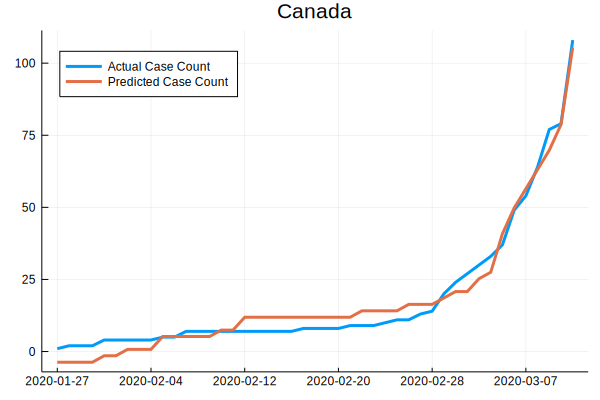

In [6]:
predicted_data = predict(ols);
plot(dates[6:end], confirmed[6:end], lw = 3, label = "Actual Case Count", title = "Canada", legend = :topleft)
plot!(dates[6:end], predicted_data, lw = 3, label = "Predicted Case Count", xticks = (dates[6:end])[1:8:end])

In [7]:
r2(ols) # R^2

0.9712125257563606

In [8]:
deviance(ols) # weighted SSR 

718.2641151416974

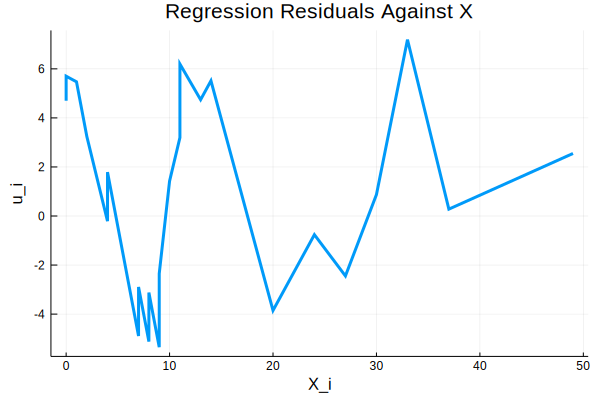

In [9]:
plot(df.X, residuals(ols), lw = 3, legend = false, title = "Regression Residuals Against X", xlabel = "X_i", ylabel = "u_i")

In [10]:
cor(df.X, residuals(ols))

-1.2738816033670616e-17

In [11]:
DurbinWatsonTest(Float64.(df.X), residuals(ols)) # check for serial correlation

Durbin-Watson autocorrelation test
----------------------------------
Population details:
    parameter of interest:   sample autocorrelation parameter
    value under h_0:         "0"
    point estimate:          0.7920867976746211

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-10

Details:
    number of observations:     45
    DW statistic:               0.4158264046507579


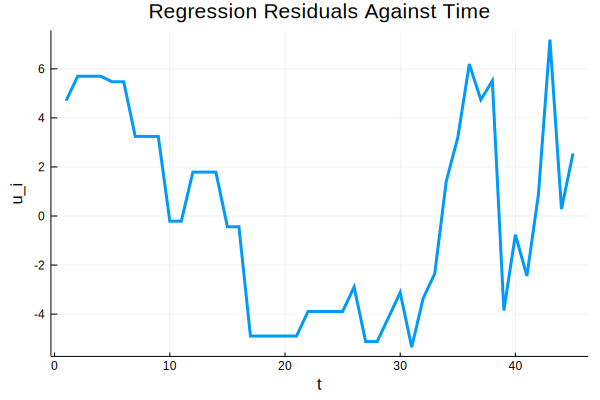

In [12]:
plot(residuals(ols), lw = 3, legend = false, title = "Regression Residuals Against Time", xlabel = "t", ylabel = "u_i")

So, although we don't notice much $\text{Cov}(u_i, X_i)$, we do see significant $\text{Cov}(u_i, i)$.

### Hypothesis Testing

We found 

$$ \hat{R}_0 = \hat{\beta}_1 = 2.22754 $$

To test our composite hypothesis, we can compute the $t$ statistic for each interval endpoint (2.06 and 2.52.) 

Testing 

$$ H_A: R_0 < 2.06 $$

In [48]:
t_left = (2.22754 - 2.06)/0.0584838 

2.8647249323744317

In [50]:
p_left = normcdf(t_left)

0.9979131419179907

Testing 

$$ H_A : R_0 > 2.52 $$

In [45]:
t_right = (2.22754 - 2.52)/0.0584838 

-5.000701048837459

In [56]:
p_right = 1 - normcdf(t_right)

0.9999997143888665

Therefore, we fail to reject both prongs of the null hypothesis, which is the Zhang et al results for the $R_0$.

(That is, under the null hypothesis, something like 99.7% of tests would produce the results we saw.)

# Pandemic Response Analysis

Another interesting question is how various countries compare to one another in their responses. 

Specifically, we're interested in whether Canada has responded "better" than the US since the WHO pandemic declaration.

So: 

$$ H_0: \text{"The two countries responded equally well.}"$$

$$ H_A: \text{"Canada responded better than the US, since the WHO declared a pandemic.}" $$

We'll make this precise shortly. 

Note that this is a **one-sided alternative hypothesis**, run with **two populations** (Canada and the US.)

### Quantifying "Success"

A natural way to capture success is to compare the empirical $\hat{R}_0$ before and after the WHO pandemic declaration. That is: 

$$ \hat{\Delta} =  \hat{R}^{\text{before Mar. 11}}_0 - \hat{R}^{\text{after Mar. 11}}_0 $$

The test is therefore: 

$$ H_0: \Delta_{\text{Canada}} - \Delta_{\text{US}} \leq 0 $$

$$ H_A: \Delta_{\text{Canada}} - \Delta_{\text{US}} > 0$$

### Preparing Data

In [17]:
canada = data["Canada"]
us = data["US"]

canada_confirmed_before = [point["confirmed"] for point in canada if Date(point["date"]) <= pandemic_day]
canada_confirmed_after = [point["confirmed"] for point in canada if Date(point["date"]) > pandemic_day]
us_confirmed_before = [point["confirmed"] for point in us if Date(point["date"]) <= pandemic_day]
us_confirmed_after = [point["confirmed"] for point in us if Date(point["date"]) > pandemic_day];

### Run Regressions

In [18]:
df_can_before = DataFrame(X=canada_confirmed_before[1:end-5], Y=canada_confirmed_before[6:end]);
df_can_after = DataFrame(X=canada_confirmed_after[1:end-5], Y=canada_confirmed_after[6:end]);
df_us_before = DataFrame(X=us_confirmed_before[1:end-5], Y=us_confirmed_before[6:end]);
df_us_after = DataFrame(X=us_confirmed_after[1:end-5], Y=us_confirmed_after[6:end]);

In [19]:
ols_can_before = lm(@formula(Y ~ X), df_can_before)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -3.69961   0.840939   -4.39939    <1e-4    -5.39553   -2.0037
X             2.22754   0.0584838  38.0881     <1e-34    2.1096     2.34548
───────────────────────────────────────────────────────────────────────────

In [20]:
ols_can_after = lm(@formula(Y ~ X), df_can_after)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────────
               Estimate   Std. Error   t value  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  1143.12     208.145       5.49191    <1e-4   707.462    1578.77
X               1.71873    0.0505082  34.0288     <1e-17    1.61302     1.82445
───────────────────────────────────────────────────────────────────────────────

In [21]:
ols_us_before = lm(@formula(Y ~ X), df_us_before)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -41.3603     8.59528  -4.81198    <1e-4   -58.6943   -24.0263
X              4.5445     0.13208  34.4072     <1e-32    4.27813    4.81086
───────────────────────────────────────────────────────────────────────────

In [22]:
ols_us_after = lm(@formula(Y ~ X), df_us_after)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                Estimate   Std. Error   t value  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)  28012.4      4842.54       5.78466    <1e-4   17876.9      38148.0
X                1.71707     0.053714  31.9668     <1e-17      1.60464      1.82949
───────────────────────────────────────────────────────────────────────────────────

### Calculate Deltas

In [57]:
Δ_canada = 2.22754 - 1.71873

0.5088099999999998

In [58]:
Δ_us = 4.5445 - 1.71707

2.82743

In [59]:
SE = 0.053714 + 0.13208 + 0.0505082 + 0.0584838 # not sure if this is valid for (B_11 - B_12) - (B_21 - B_22) where each B is a slope, but seems like a decent upper bound... i.e., add up the standard error of each term independently

0.294786

### Test Hypotheses

In [60]:
z = (Δ_canada - Δ_us)/0.294786

-7.865434586445761

In [61]:
1 - normcdf(z)

0.9999999999999981

Since our $p$-value here is 99.999999999999%, we fail to reject the null...